In [9]:
import numpy as np
import pandas as pd
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import logging

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logging.basicConfig(
    filename="experiments.log",
    filemode="w",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s" 
)

In [3]:
ARR_LENS = list(range(100_000, 10_000_001, 100_000))
S_VALUES = list(range(10, 101, 10)) # 10 to 100

In [4]:
class DataLoader:
    def __init__(self, arr_len):
        self.arr_len = arr_len
        
    def generate_data(self):
        return np.random.randint(1, self.arr_len, self.arr_len)

In [5]:
class Model:

    def __init__(self, array, S):
        self.S = S   
        self.array = array

    def train(self):
        self.execution_time = None
        self.key_cmp = 0
        start_time = time.perf_counter()
        self.merge_insertion_sort(0, len(self.array)-1)
        end_time = time.perf_counter()
        self.execution_time = end_time - start_time

    def merge(self, n, m):
        mid = (n + m) // 2
        left = self.array[n:mid + 1]
        right = self.array[mid + 1:m + 1]

        i = j = 0

        temp = []

        while i < len(left) and j < len(right):
            self.key_cmp += 1
            if left[i] <= right[j]:  # Stable sort: left[i] goes first if equal
                temp.append(left[i])
                i += 1
            else:
                temp.append(right[j])
                j += 1

        # Add any remaining elements
        while i < len(left):
            temp.append(left[i])
            i += 1

        while j < len(right):
            temp.append(right[j])
            j += 1

        # Copy merged values back into original array
        self.array[n:m+1] = temp


    def merge_insertion_sort(self, n, m):
        
        if (m-n <= 0):
            return
        
        if m-n+1 <= self.S:
            self.insertion_sort(n, m)
            return
        
        mid = (n+m)//2
        if (m-n>1):
            self.merge_insertion_sort(n, mid)
            self.merge_insertion_sort(mid+1, m)
        
        self.merge(n, m)

    def merge_sort(self, n, m):
        if (m-n <= 0):
            return
        
        mid = (n+m)//2
        if (m-n>1):
            self.merge_sort(n, mid)
            self.merge_sort(mid+1, m)
        
        self.merge(n, m)

    def insertion_sort(self, n, m):
        i = n+1
        while i <= m:
            j = i
            while j > n:
                self.key_cmp += 1
                if self.array[j] < self.array[j-1]:
                    tmp = self.array[j]
                    self.array[j] = self.array[j-1]
                    self.array[j-1] = tmp
                    j -= 1
                else:
                    break
            i+=1

In [6]:
def run_experiment(args):
    arr_len, S = args
    dataloader = DataLoader(arr_len=arr_len)
    array = dataloader.generate_data()

    model = Model(array, S)

    logging.info(f"Starting sort for arr_len={arr_len} with S={S}")
    model.train()
    logging.info(f"Completed sort for arr_len={arr_len} with S={S}")

    return {
        "Array Length": arr_len,
        "Threshold": S,
        "Execution Time": model.execution_time,
        "Key Comparisons": model.key_cmp
    }

In [7]:
# TEST
arr_len = 30
S=3

dataloader = DataLoader(arr_len=arr_len)
array = dataloader.generate_data()

model = Model(array, S)

print(model.array)
model.train()
print(model.array)

[24 28  2  8  6 11 16 29 19 20 15  3 11 24 25 19 17  5  3  6 16 23 19 11
 22 11 16 12 27 17]
[ 2  3  3  5  6  6  8 11 11 11 11 12 15 16 16 16 17 17 19 19 19 20 22 23
 24 24 25 27 28 29]


In [8]:
experiments = [(arr_len, S) for arr_len in ARR_LENS for S in S_VALUES]

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(run_experiment, experiments), total=len(experiments), desc="Processing Arrays"))

df_results = pd.DataFrame(results)
df_results.to_parquet("baseline.parquet", index=False)

print("Execution complete")

Processing Arrays: 100%|██████████| 1010/1010 [16:22<00:00,  1.03it/s]


Execution complete


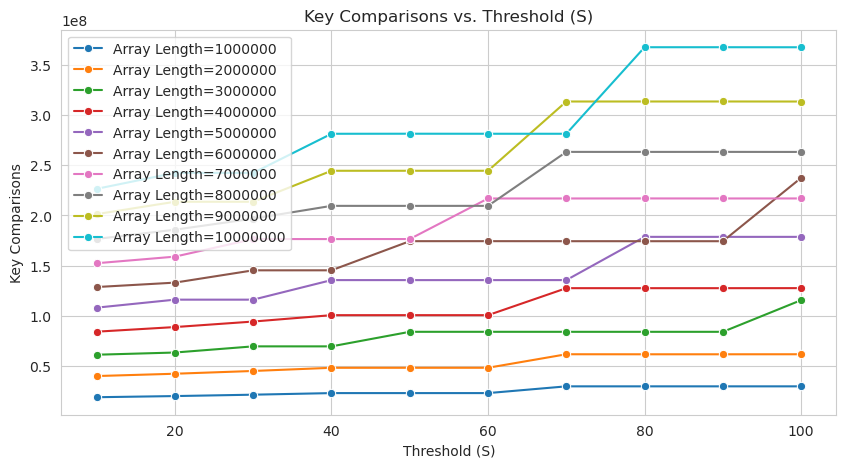

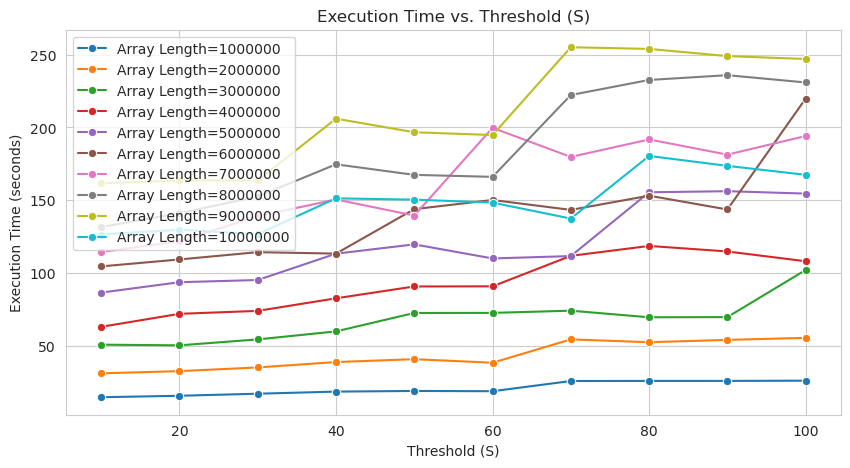

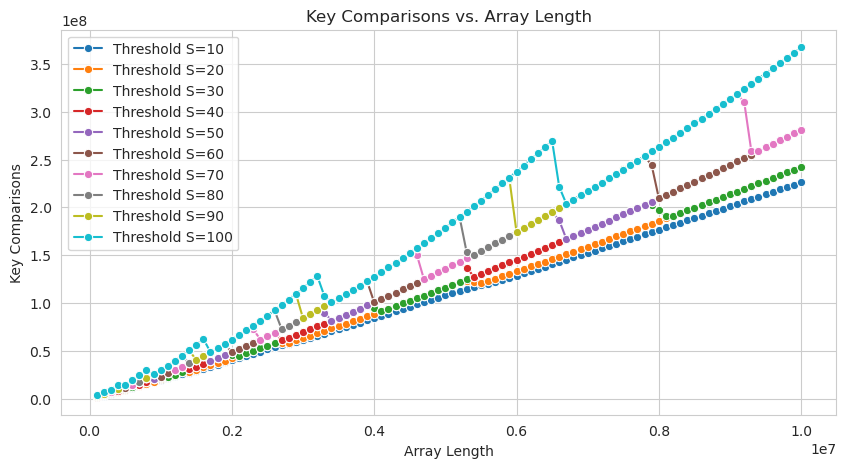

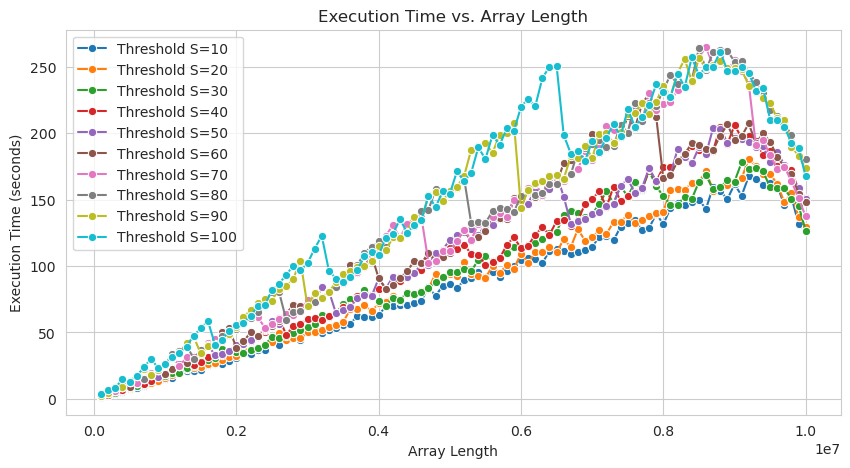

In [ ]:
experiments = [(arr_len, S) for arr_len in ARR_LENS for S in S_VALUES]

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(run_experiment, experiments), total=len(experiments), desc="Processing Arrays"))

df_results = pd.DataFrame(results)
df_results.to_parquet("results.parquet", index=False)

print("Execution complete")